In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from PIL import Image
from tqdm.auto import tqdm

In [2]:
def get_results(path):
    with open(path, 'r') as f:
        data = json.load(f)
    return data

def score(res):
    return res['answer'] == res['response']

In [3]:
def concatenate_datasets(sub_dataset_list):
    from datasets import concatenate_datasets
    combined = concatenate_datasets(sub_dataset_list)
    return combined

def load_dataset(data_path, subject, split="validation"):
    from datasets import load_dataset
    ds = load_dataset(data_path, subject, split=split)
    return ds



In [4]:
subject = "Manage"

dset = load_dataset("MMMU/MMMU", subject, split="validation")

In [5]:
all_subs = [
    'Accounting', 'Agriculture', 'Architecture_and_Engineering', 'Art',
    'Art_Theory','Basic_Medical_Science','Biology','Chemistry','Clinical_Medicine',
    'Computer_Science','Design','Diagnostics_and_Laboratory_Medicine','Economics',
    'Electronics','Energy_and_Power','Finance','Geography','History','Literature',
    'Manage','Marketing','Materials','Math','Mechanical_Engineering','Music',
    'Pharmacy','Physics','Psychology','Public_Health','Sociology'
]

sub_dataset_list = [load_dataset("MMMU/MMMU", subject, split="validation") for subject in all_subs]
dset = concatenate_datasets(sub_dataset_list)

In [6]:
base_data = []
text_data = []
img_data = []
both_data = []
text_noop_data = []
img_noop_data = []


for subject in tqdm(all_subs):
    base_results_path = f"/u/li19/MMMU/mmmu/results/base_scores/parse_and_eval/{subject}/output.json"
    base_data += get_results(base_results_path)
    text_results_path = f"/u/li19/MMMU/mmmu/results/llava_one_old/llava_text_NoOp/parse_and_eval/{subject}/output.json"
    text_data += get_results(text_results_path)
    img_results_path = f"/u/li19/MMMU/mmmu/results/llava_one_old/llava_img_NoOp/parse_and_eval/{subject}/output.json"
    img_data += get_results(img_results_path)
    both_results_path = f"/u/li19/MMMU/mmmu/results/llava_one_old/llava_all_NoOp/parse_and_eval/{subject}/output.json"
    both_data += get_results(both_results_path)
    
text_noop_path = "/u/li19/MMMU/mmmu-noop/mmmu_validation_noop_insert_sentence.json"
text_noop_data = get_results(text_noop_path)
img_noop_path = "/u/li19/MMMU/mmmu-noop/val_img_NoOp_metadata.json"
img_noop_data = get_results(img_noop_path)

  0%|          | 0/30 [00:00<?, ?it/s]

In [7]:
q_lookup = {}
for question in dset:
    q_lookup[question['id']] = question
print("Finished: ", "q_lookup")

base_lookup = {}
for question in base_data:
    base_lookup[question['id']] = question
print("Finished: ", "base_lookup")

text_lookup = {}
for question in text_data:
    text_lookup[question['id']] = question
print("Finished: ", "text_lookup")

img_lookup = {}
for question in img_data:
    img_lookup[question['id']] = question
print("Finished: ", "img_lookup")

both_lookup = {}
for question in both_data:
    both_lookup[question['id']] = question
print("Finished: ", "both_lookup")


Finished:  q_lookup
Finished:  base_lookup
Finished:  text_lookup
Finished:  img_lookup
Finished:  both_lookup


In [32]:
def question_inspect(qid):
    question = q_lookup[qid]
    base_text = question['question']
    base_img = question['image_1']

    noOp_text = text_noop_data[qid]
    noOp_img_path = img_noop_data[qid]
    noOp_img = Image.open(noOp_img_path['image_paths'][0]+".png")
    print("======== REAL ========: ", qid)
    print(base_text)
    print("======== NoOp ========")
    print(noOp_text)
    print("======== ANSWERS ========")
    print(question['options'])
    fig, axs = plt.subplots(1, 2, figsize=(10,5))

    axs[0].imshow(question['image_1'])
    axs[1].imshow(noOp_img)
    plt.show()

    print(f"======== ANSWERS: {question['answer']} ========")
    base = base_lookup[qid]
    print("base: ", base['response'])
    text = text_lookup[qid]
    print("text: ", text['response'])
    img = img_lookup[qid]
    print("img: ", img['response'])
    both = both_lookup[qid]
    print("both: ", both['response'])
    

In [35]:
checks = []
for qid in q_lookup.keys():
    base = base_lookup[qid]
    text = text_lookup[qid]
    img = img_lookup[qid]
    both = both_lookup[qid]


    base_score = score(base)
    text_score = score(text)
    img_score = score(img)
    both_score = score(both)

    # Check if all boolean values are equal
    are_all_equal = len(set([bool(base_score), bool(text_score), bool(img_score), bool(both_score)])) == 1

    # if not are_all_equal:
    #     line = f"{qid}: {base_score} - {text_score} - {img_score} - {both_score}"
    #     print(line)

    if not img_score and not text_score and not both_score and base_score:
        checks.append(qid)

In [36]:
checks

['validation_Accounting_29',
 'validation_Art_17',
 'validation_Art_Theory_22',
 'validation_Basic_Medical_Science_21',
 'validation_Biology_24',
 'validation_Clinical_Medicine_25',
 'validation_Computer_Science_20',
 'validation_Design_18',
 'validation_Energy_and_Power_1',
 'validation_Finance_5',
 'validation_Geography_6',
 'validation_History_9',
 'validation_Literature_25']

======== REAL ========:  validation_Accounting_29
You are asked to compare two options with parameters as given. The risk-free interest rate should be assumed to be 6%. Assume the stocks on which these options are written pay no dividends. <image 1> Which call option is written on the stock with the higher volatility?
======== NoOp ========
You are asked to compare two options with parameters as given. The risk-free interest rate should be assumed to be 6%. Assume the stocks on which these options are written pay no dividends. <image 1> Which call option is written on the stock with the higher volatility? The company's financial reports are available online.
======== ANSWERS ========
['A', 'B', 'Not enough information']


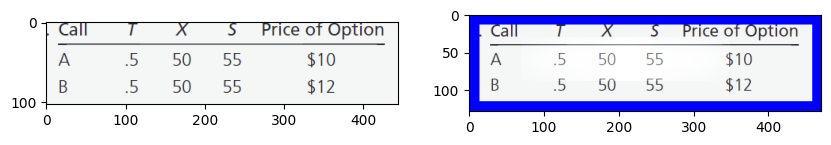

======== ANSWERS: B ========
base:  B
text:  C
img:  A
both:  C
--------------------------------------------------
======== REAL ========:  validation_Art_17
Mayan chacmool sculptures such as this one heavily influenced which of the following twentieth-century sculptors? <image 1>
======== NoOp ========
Mayan chacmool sculptures such as this one heavily influenced which of the following twentieth-century sculptors? <image 1> The artist's studio was filled with the scent of fresh coffee.
======== ANSWERS ========
['Louise Bourgeois', 'Henry Moore', 'Barbara Hepworth', 'Constantin Brancusi']


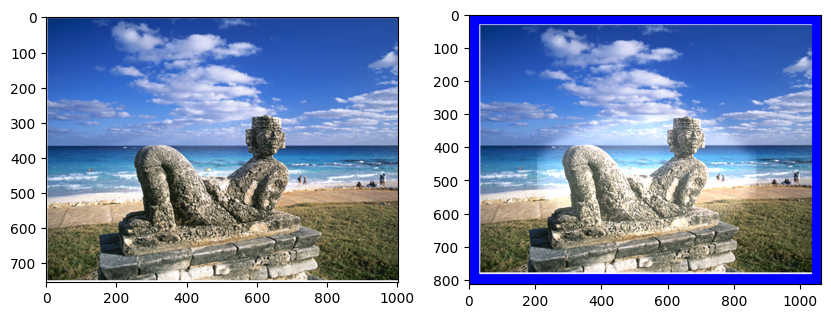

======== ANSWERS: B ========
base:  B
text:  D
img:  D
both:  D
--------------------------------------------------
======== REAL ========:  validation_Art_Theory_22
The work functioned as <image 1>
======== NoOp ========
The work functioned as <image 1> while the artist was sipping a cup of coffee.
======== ANSWERS ========
['an icon', 'a book cover', 'an altarpiece', 'a purse lid']


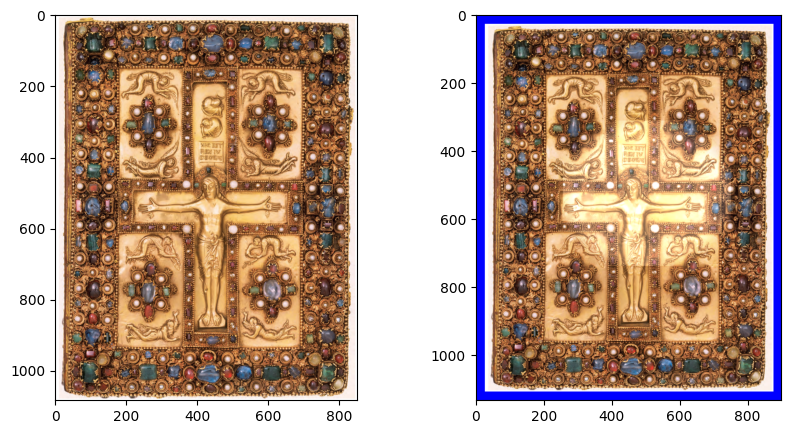

======== ANSWERS: B ========
base:  B
text:  A
img:  C
both:  A
--------------------------------------------------
======== REAL ========:  validation_Basic_Medical_Science_21
The thickened portion of the septum pellucidum represents <image 1> 
======== NoOp ========
The thickened portion of the septum pellucidum represents <image 1> which is often overlooked in medical history books.
======== ANSWERS ========
['The fornix', 'The septal nuclei', 'Both.', 'Neither.']


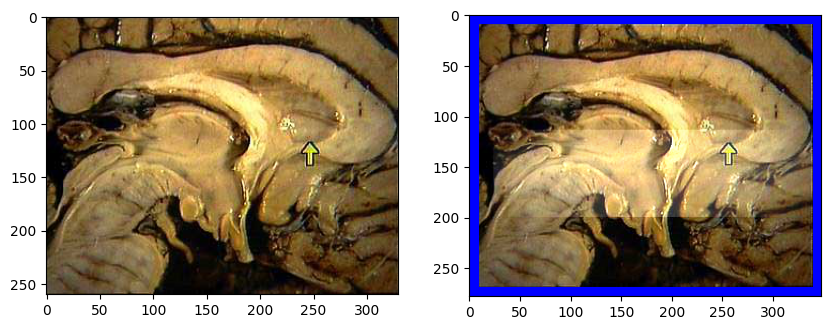

======== ANSWERS: B ========
base:  B
text:  A
img:  A
both:  A
--------------------------------------------------
======== REAL ========:  validation_Biology_24
Which image of the human heart muscle was produced by fluorescent microscopy?
======== NoOp ========
Which image of the human heart muscle was produced by fluorescent microscopy? The lab is located on the third floor.
======== ANSWERS ========
['<image 1>', '<image 2>', '<image 3>']


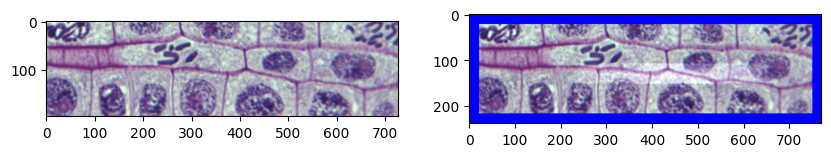

======== ANSWERS: C ========
base:  C
text:  C)
img:  C)
both:  C)
--------------------------------------------------
======== REAL ========:  validation_Clinical_Medicine_25
A 39-year-old woman has noted a 'bump' on her neck for the past 6 months. On physical examination there is a firm, well-circumscribed, non-tender nodule to the right of midline in her neck. She undergoes thyroidectomy and the microscopic appearance of the lesion is shown here. Which of the following statements regarding her disease is most appropriate? <image 1> 
======== NoOp ========
A 39-year-old woman has noted a 'bump' on her neck for the past 6 months. On physical examination there is a firm, well-circumscribed, non-tender nodule to the right of midline in her neck. the patient's favorite book is a classic novel. She undergoes thyroidectomy and the microscopic appearance of the lesion is shown here. Which of the following statements regarding her disease is most appropriate? <image 1>
======== ANSWERS ======

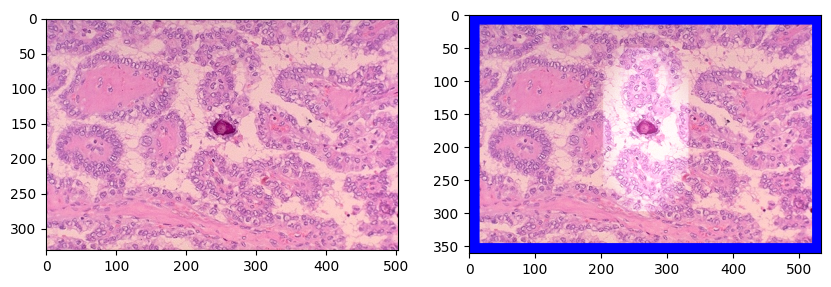

======== ANSWERS: B ========
base:  B
text:  C
img:  C
both:  C
--------------------------------------------------
======== REAL ========:  validation_Computer_Science_20
Can you add an DEPARTMENT if there are no EMPLOYEEs in the database in <image 1>?
======== NoOp ========
Can you add an DEPARTMENT if there are no EMPLOYEEs in the database in <image 1>? the code is written in a quiet coffee shop.
======== ANSWERS ========
['Yes', 'No', "Can't tell"]


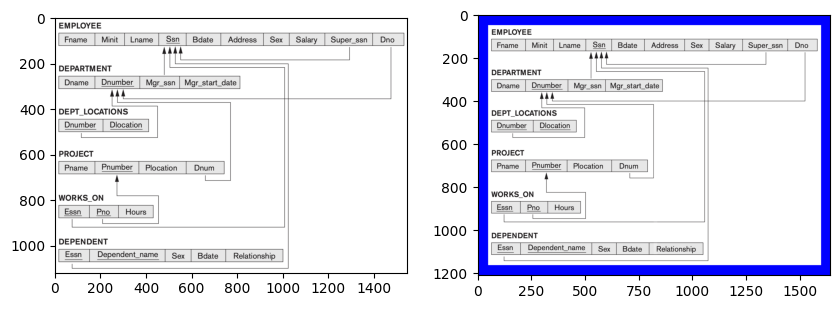

======== ANSWERS: A ========
base:  A
text:  B
img:  B
both:  B
--------------------------------------------------
======== REAL ========:  validation_Design_18
How does a designer resolve a design?<image 1>
======== NoOp ========
How does a designer resolve a design?<image 1> while sipping a warm cup of coffee.
======== ANSWERS ========
['By sketching multiple design ideas', 'By conducting user testing', 'By creating a presentation and developing the design into a publishable format that addresses all evaluation criteria', 'By refining typography and layout']


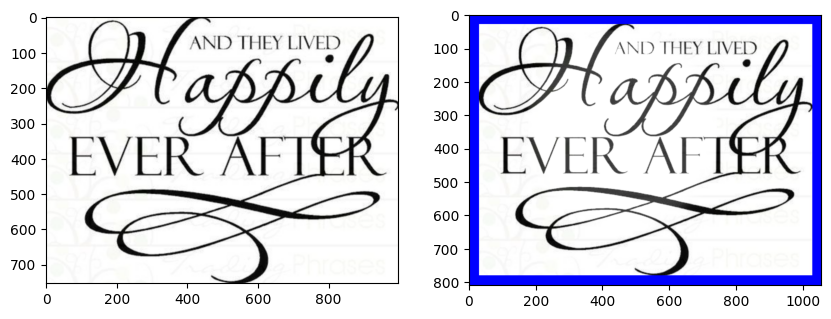

======== ANSWERS: C ========
base:  C
text:  D
img:  C)
both:  D
--------------------------------------------------
======== REAL ========:  validation_Energy_and_Power_1
<image 1>A transistor, which may be approximated as a hemispherical heat source of radius ro = 0.1 mm, is embedded in a large silicon substrate (k = 125 W/m$\cdot$  K) and dissipates heat at a rate q. All boundaries of the silicon are maintained at an ambient temperature of T$\infty$= 27C,except for the top surface, which is well insulated.evaluate the surface temperature of the heat source for q =4 W.
======== NoOp ========
<image 1>A transistor, which may be approximated as a hemispherical heat source of radius ro = 0.1 mm, is embedded in a large silicon substrate (k = 125 W/m$\cdot$  K) and dissipates heat at a rate q. The calculation is performed using a computer program. All boundaries of the silicon are maintained at an ambient temperature of T$\infty$= 27C,except for the top surface, which is well insulated.eva

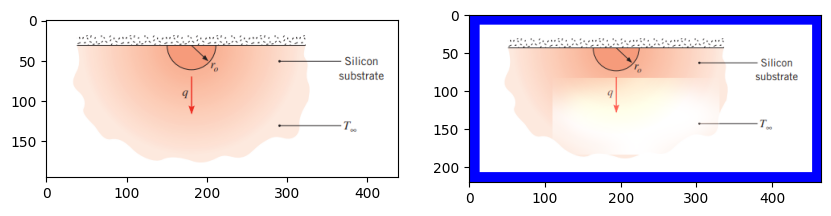

======== ANSWERS: B ========
base:  B
text:  C
img:  C
both:  C
--------------------------------------------------
======== REAL ========:  validation_Finance_5
As financial manager of Corton Inc., you are investigating a possible acquisition of Denham. You have the basic data given in the following table. You estimate that investors expect a steady growth of about 6% in Denham's earnings and dividends. Under new management, this growth rate would be increased to 8% per year without the need for additional capital. <image 1> How would the cost of the share offer change if the expected growth rate was not changed by the merger?
======== NoOp ========
As financial manager of Corton Inc., you are investigating a possible acquisition of Denham. You have the basic data given in the following table. You estimate that investors expect a steady growth of about 6% in Denham's earnings and dividends. Under new management, this growth rate would be increased to 8% per year without the need for ad

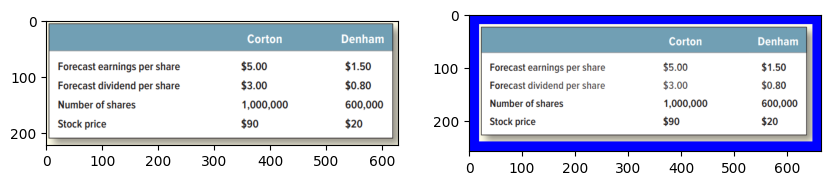

======== ANSWERS: D ========
base:  D
text:  B
img:  B
both:  B
--------------------------------------------------
======== REAL ========:  validation_Geography_6
As shown in the diagram, the bending moment MDA (unit: kN? M) is equal to<image 1>
======== NoOp ========
As shown in the diagram, the bending moment MDA (unit: kN? M) is equal to<image 1> the city's mayor is planning a new park.
======== ANSWERS ========
['12', '15', '18', '24']


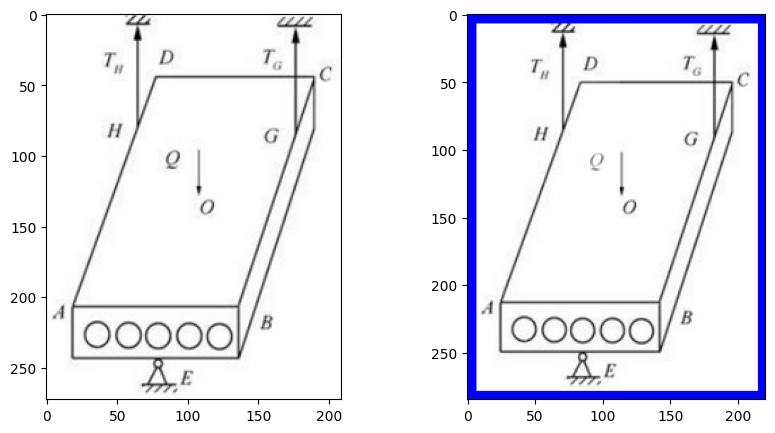

======== ANSWERS: C ========
base:  C
text:  B
img:  A
both:  B
--------------------------------------------------
======== REAL ========:  validation_History_9
<image 1> Which event in Native American history is LEAST similar to the migration depicted in the map above?
======== NoOp ========
<image 1> Which event in Native American history is LEAST similar to the migration depicted in the map above? The aroma of freshly brewed coffee filled the air.
======== ANSWERS ========
['The Trail of Tears', "King Philip's War", 'Creek War of 1836', 'The Battle of Little Big Horn']


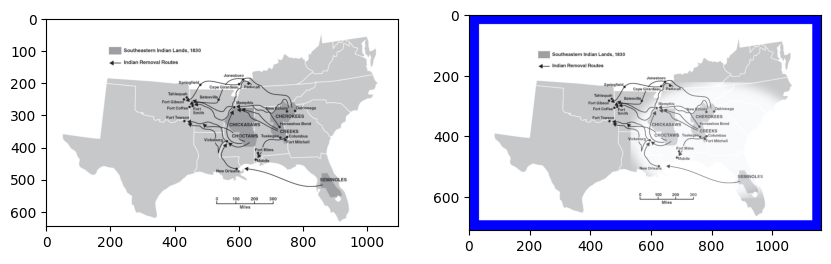

======== ANSWERS: B ========
base:  B
text:  B)
img:  B)
both:  B)
--------------------------------------------------
======== REAL ========:  validation_Literature_25
Refer to the figure <image 1>, which term best describes the field that deals with living organisms and the laws and phenomena that relate to any organism or group of organisms?
======== NoOp ========
Refer to the figure <image 1>, which term best describes the field that deals with living organisms and the laws and phenomena that relate to any organism or group of organisms? The author's favorite book is a classic novel.
======== ANSWERS ========
['Science Fiction', 'Biological Science', 'Physical Science Or Natural Science', 'Applied Science']


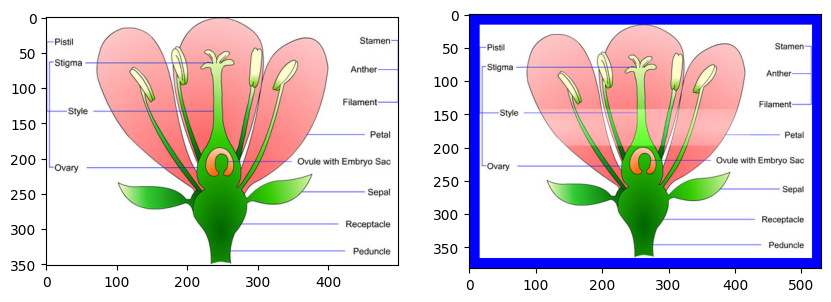

======== ANSWERS: B ========
base:  B
text:  B) Biological Science
img:  B) Biological Science
both:  B) Biological Science
--------------------------------------------------


In [37]:
for c in checks:
    question_inspect(c)
    print("--------------------------------------------------")